---
# Problema 2 — **Fruits and Vegetables Recognizer (CNN)**

**Objetivo:** Construir un clasificador de imágenes (CNN) capaz de distinguir al menos **3 frutas** y **3 verduras**, aplicando **data augmentation** y evaluando **3 arquitecturas** diferentes.  
Se recomienda usar el dataset de **Kaggle** indicado en el enunciado, descomprimirlo y **apuntar la ruta** a continuación.


**Instalación de librerías**

In [ ]:
try:
    import tensorflow as tf
except Exception:
    %pip install tensorflow-cpu==2.15.0

%pip install scikit-learn matplotlib pandas


**Configuración de rutas y combinación de clases**

In [ ]:
from pathlib import Path

# Ruta de la carpeta donde se encuentran los archivos
ALIMENTOS_DIR = Path(r"C:\Users\Yeimi\OneDrive\Documentos\Maestría\2 año\03 Trimestre\Text Mining & Image Recognition\Tareas\Proyecto\Alimentos")

FRUITS_DIR     = ALIMENTOS_DIR / "Frutas"
VEGETABLES_DIR = ALIMENTOS_DIR / "Verduras"

print("Alimentos:", ALIMENTOS_DIR.resolve())
print("Frutas   :", FRUITS_DIR.resolve())
print("Verduras :", VEGETABLES_DIR.resolve())

assert ALIMENTOS_DIR.exists(),  "No existe la carpeta 'Alimentos'. Corrige ALIMENTOS_DIR."
assert FRUITS_DIR.exists(),     "No existe 'Alimentos/Frutas'."
assert VEGETABLES_DIR.exists(), "No existe 'Alimentos/Verduras'."


Alimentos: C:\Users\Yeimi\OneDrive\Documentos\Maestría\2 año\03 Trimestre\Text Mining & Image Recognition\Tareas\Proyecto\Alimentos
Frutas   : C:\Users\Yeimi\OneDrive\Documentos\Maestría\2 año\03 Trimestre\Text Mining & Image Recognition\Tareas\Proyecto\Alimentos\Frutas
Verduras : C:\Users\Yeimi\OneDrive\Documentos\Maestría\2 año\03 Trimestre\Text Mining & Image Recognition\Tareas\Proyecto\Alimentos\Verduras


**Combinación de las 6 clases en una sola raíz**

In [ ]:
import os, shutil

COMBINED_DIR = Path("./dataset_6clases")   # destino donde quedarán las 6 clases juntas
COMBINED_DIR.mkdir(parents=True, exist_ok=True)

def copy_class_dir(src_dir: Path, dst_root: Path):
    """Copia todas las subcarpetas (clases) desde src_dir a dst_root sin borrar lo existente."""
    copied = []
    classes = sorted([d for d in src_dir.iterdir() if d.is_dir()])
    if not classes:
        print(f"⚠️ No se encontraron clases en: {src_dir}")
        return copied

    for cls in classes:
        dst = dst_root / cls.name
        dst.mkdir(parents=True, exist_ok=True)
        for root, _, files in os.walk(cls):
            rel = Path(root).relative_to(cls)
            (dst / rel).mkdir(parents=True, exist_ok=True)
            for fn in files:
                s = Path(root) / fn
                d = (dst / rel / fn)
                if not d.exists():
                    try:
                        shutil.copy2(s, d)
                    except Exception as e:
                        print(f"Aviso: no se pudo copiar {s} → {d}: {e}")
        copied.append(dst)
    return copied

print("Copiando FRUTAS →", COMBINED_DIR.resolve())
_ = copy_class_dir(FRUITS_DIR, COMBINED_DIR)

print("Copiando VERDURAS →", COMBINED_DIR.resolve())
_ = copy_class_dir(VEGETABLES_DIR, COMBINED_DIR)

classes = sorted([d.name for d in COMBINED_DIR.iterdir() if d.is_dir()])
print("\n Clases finales en dataset combinado:", classes)
assert len(classes) == 6, f"Se esperaban 6 clases (3 frutas + 3 verduras). Encontradas: {len(classes)} → {classes}"


📦 Copiando FRUTAS → C:\Users\Yeimi\OneDrive\Documentos\Maestría\2 año\03 Trimestre\Text Mining & Image Recognition\Tareas\Proyecto\dataset_6clases
🥦 Copiando VERDURAS → C:\Users\Yeimi\OneDrive\Documentos\Maestría\2 año\03 Trimestre\Text Mining & Image Recognition\Tareas\Proyecto\dataset_6clases

✅ Clases finales en dataset combinado: ['FreshMango', 'FreshOrange', 'FreshStrawberry', 'RottenBellpepper', 'RottenCarrot', 'RottenTomato']


*Uso del dataset creado*

In [8]:
DATA_DIR = COMBINED_DIR

#Mostrar tamaño por clase
from collections import defaultdict
import os

counts = defaultdict(int)
for cls in sorted([d for d in DATA_DIR.iterdir() if d.is_dir()]):
    for _, _, files in os.walk(cls):
        counts[cls.name] += len(files)
counts


defaultdict(int,
            {'FreshMango': 605,
             'FreshOrange': 609,
             'FreshStrawberry': 603,
             'RottenBellpepper': 591,
             'RottenCarrot': 580,
             'RottenTomato': 596})

**Carga de datos**

In [ ]:
%pip install Unidecode

In [24]:
from pathlib import Path
import os, shutil, re
from unidecode import unidecode

# Origen: tu dataset combinado actual
SRC_DIR = Path("./dataset_6clases")  
assert SRC_DIR.exists(), f"No existe {SRC_DIR.resolve()}"

# Destino: ruta ASCII segura y corta
SAFE_DIR = Path(r"C:\data\dataset_6clases_ascii")  # <- crea C:\data si no existe
SAFE_DIR.mkdir(parents=True, exist_ok=True)

def normalize_name(name:str) -> str:
    # quita acentos → ascii, cambia espacios por _, y elimina símbolos raros
    s = unidecode(name)
    s = s.replace(" ", "_")
    s = re.sub(r"[^A-Za-z0-9_\-\.]", "", s)
    return s

def copy_and_normalize_tree(src: Path, dst: Path):
    for root, dirs, files in os.walk(src):
        root = Path(root)
        # ruta relativa desde src
        rel = root.relative_to(src)

        # normalizar cada componente del path relativo
        rel_norm_parts = [normalize_name(p) for p in rel.parts]
        dst_root = dst.joinpath(*rel_norm_parts)
        dst_root.mkdir(parents=True, exist_ok=True)

        # copiar/normalizar subcarpetas (para que os.walk siga usando las originales)
        for d in dirs:
            (dst_root / normalize_name(d)).mkdir(exist_ok=True)

        # copiar archivos (solo imágenes comunes)
        for fn in files:
            if not re.search(r"\.(jpg|jpeg|png|bmp|gif|webp)$", fn, re.IGNORECASE):
                continue
            src_file = root / fn
            dst_file = dst_root / normalize_name(fn)
            if not dst_file.exists():
                try:
                    shutil.copy2(src_file, dst_file)
                except Exception as e:
                    print(f"Aviso: no se pudo copiar {src_file} → {dst_file}: {e}")

copy_and_normalize_tree(SRC_DIR, SAFE_DIR)
print("Copiado y normalizado en:", SAFE_DIR.resolve())
print("Clases detectadas:", [d.name for d in SAFE_DIR.iterdir() if d.is_dir()])


Copiado y normalizado en: C:\data\dataset_6clases_ascii
Clases detectadas: ['FreshMango', 'FreshOrange', 'FreshStrawberry', 'RottenBellpepper', 'RottenCarrot', 'RottenTomato']


*Carga de datos y splits (train/val/test)*

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DATA_DIR   = SAFE_DIR  # 👈 usar la ruta segura
IMG_SIZE   = (160, 160)
BATCH_SIZE = 32
SEED       = 42
VAL_SPLIT  = 0.2
AUTO       = tf.data.AUTOTUNE

CLASS_NAMES = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
print("Clases:", CLASS_NAMES)

train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES,
    validation_split=VAL_SPLIT, subset='training', seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_full = keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES,
    validation_split=VAL_SPLIT, subset='validation', seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

val_batches = tf.data.experimental.cardinality(val_full)
val_take = max(1, val_batches // 2)
val_ds  = val_full.take(val_take)
test_ds = val_full.skip(val_take)

def optimize(ds, training=False):
    return (ds.shuffle(1000, seed=SEED) if training else ds).cache().prefetch(AUTO)

train_ds = optimize(train_ds, training=True)
val_ds   = optimize(val_ds)
test_ds  = optimize(test_ds)

NUM_CLASSES = len(CLASS_NAMES)
NUM_CLASSES


Clases: ['FreshMango', 'FreshOrange', 'FreshStrawberry', 'RottenBellpepper', 'RottenCarrot', 'RottenTomato']
Found 3582 files belonging to 6 classes.
Using 2866 files for training.
Found 3582 files belonging to 6 classes.
Using 716 files for validation.


6

- Verificación del data set cargado

In [17]:
from pathlib import Path
import os, shutil
from PIL import Image

# usa la misma DATA_DIR que ya definiste (SAFE_DIR o COMBINED_DIR)
assert 'DATA_DIR' in globals(), "Primero define DATA_DIR como la carpeta raíz con las 6 clases"

# Extensiones permitidas por tf.keras (Pillow) en esta receta
ALLOWED = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}  # OJO: .webp suele fallar

QUARANTINE = Path("./bad_images")
QUARANTINE.mkdir(exist_ok=True)

bad_list = []

def is_valid_image(path: Path) -> bool:
    try:
        # abre y verifica que la imagen se puede leer
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception:
        return False

for root, _, files in os.walk(DATA_DIR):
    for fn in files:
        p = Path(root) / fn
        ext = p.suffix.lower()
        # 1) extensión no permitida → cuarentena
        if ext not in ALLOWED:
            dst = QUARANTINE / p.name
            shutil.move(str(p), str(dst))
            bad_list.append((str(p), "ext_not_allowed"))
            continue
        # 2) archivo con extensión válida pero corrupto → cuarentena
        if not is_valid_image(p):
            dst = QUARANTINE / p.name
            shutil.move(str(p), str(dst))
            bad_list.append((str(p), "corrupt"))
            
print(f"Archivos movidos a cuarentena: {len(bad_list)}")
len(bad_list) and bad_list[:10]


Archivos movidos a cuarentena: 2


[('C:\\data\\dataset_6clases_ascii\\RottenCarrot\\rottenCarrot_1.webp',
  'ext_not_allowed'),
 ('C:\\data\\dataset_6clases_ascii\\RottenTomato\\rottenTomato_1.webp',
  'ext_not_allowed')]

In [19]:
import tensorflow as tf
from tensorflow import keras

VAL_SPLIT = 0.2
SEED = 42
IMG_SIZE = (160,160)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

CLASS_NAMES = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES, validation_split=VAL_SPLIT,
    subset='training', seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_full = keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES, validation_split=VAL_SPLIT,
    subset='validation', seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_batches = tf.data.experimental.cardinality(val_full)
val_take = max(1, val_batches // 2)
val_ds  = val_full.take(val_take)
test_ds = val_full.skip(val_take)

def optimize(ds, training=False):
    return (ds.shuffle(1000, seed=SEED) if training else ds).cache().prefetch(AUTO)

train_ds = optimize(train_ds, training=True)
val_ds   = optimize(val_ds)
test_ds  = optimize(test_ds)


Found 3582 files belonging to 6 classes.
Using 2866 files for training.
Found 3582 files belonging to 6 classes.
Using 716 files for validation.


In [21]:
from pathlib import Path
import os, shutil, re
import tensorflow as tf

# Usa la raíz actual del dataset (la que pasas a image_dataset_from_directory)
assert 'DATA_DIR' in globals(), "Define DATA_DIR antes (tu carpeta con las 6 clases)"
DATA_DIR = Path(DATA_DIR)
print("Escaneando:", DATA_DIR.resolve())

ALLOWED = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}  # lo mismo que usa Keras
QUARANTINE_TF = Path("./bad_images_tf")
QUARANTINE_TF.mkdir(exist_ok=True)

def tf_check_image(path: Path):
    """Intenta decodificar con TF según extensión; si falla, lanza excepción."""
    raw = tf.io.read_file(str(path))
    ext = path.suffix.lower()
    if ext in (".jpg", ".jpeg"):
        _ = tf.image.decode_jpeg(raw, channels=3)
    elif ext == ".png":
        _ = tf.image.decode_png(raw, channels=3)
    elif ext == ".bmp":
        _ = tf.image.decode_bmp(raw)
    elif ext == ".gif":
        # GIF decodifica con 4D (frames, h, w, c); convertimos 1er frame a 3 canales
        gif = tf.image.decode_gif(raw)
        _  = tf.image.resize(gif[0], (10,10))  # solo para forzar lectura
    else:
        raise ValueError("Extensión no permitida")

bad = []
count = 0
for root, _, files in os.walk(DATA_DIR):
    for fn in files:
        p = Path(root) / fn
        ext = p.suffix.lower()
        if ext not in ALLOWED:
            # mover de una vez
            shutil.move(str(p), str(QUARANTINE_TF / p.name))
            bad.append((str(p), "ext_not_allowed"))
            continue
        try:
            tf_check_image(p)   # <-- prueba real con TF
            count += 1
        except Exception as e:
            # archivo conflictivo -> a cuarentena
            dst = QUARANTINE_TF / p.name
            try:
                shutil.move(str(p), str(dst))
            except Exception:
                # si existe un homónimo, renombra
                i = 1
                while dst.exists():
                    dst = QUARANTINE_TF / f"{p.stem}_{i}{p.suffix}"
                    i += 1
                shutil.move(str(p), str(dst))
            bad.append((str(p), type(e).__name__))

print(f"✅ Imágenes válidas: {count}")
print(f"⚠️ Movidas a cuarentena TF: {len(bad)}")
bad[:10]


Escaneando: C:\data\dataset_6clases_ascii
✅ Imágenes válidas: 3581
⚠️ Movidas a cuarentena TF: 1


[('C:\\data\\dataset_6clases_ascii\\RottenBellpepper\\rottenPepper_1.jpg',
  'InvalidArgumentError')]

In [22]:
import tensorflow as tf
from tensorflow import keras

VAL_SPLIT = 0.2
SEED = 42
IMG_SIZE = (160,160)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

CLASS_NAMES = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
print("Clases:", CLASS_NAMES)

train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES, validation_split=VAL_SPLIT,
    subset='training', seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_full = keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES, validation_split=VAL_SPLIT,
    subset='validation', seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

val_batches = tf.data.experimental.cardinality(val_full)
val_take = max(1, val_batches // 2)
val_ds  = val_full.take(val_take)
test_ds = val_full.skip(val_take)

def optimize(ds, training=False):
    return (ds.shuffle(1000, seed=SEED) if training else ds).cache().prefetch(AUTO)

train_ds = optimize(train_ds, training=True)
val_ds   = optimize(val_ds)
test_ds  = optimize(test_ds)

print("Datasets reconstruidos ✔️")


Clases: ['FreshMango', 'FreshOrange', 'FreshStrawberry', 'RottenBellpepper', 'RottenCarrot', 'RottenTomato']
Found 3581 files belonging to 6 classes.
Using 2865 files for training.
Found 3581 files belonging to 6 classes.
Using 716 files for validation.
Datasets reconstruidos ✔️


*Chequeo visual rápido*

Número de clases: 6
Clases: ['FreshMango', 'FreshOrange', 'FreshStrawberry', 'RottenBellpepper', 'RottenCarrot', 'RottenTomato']


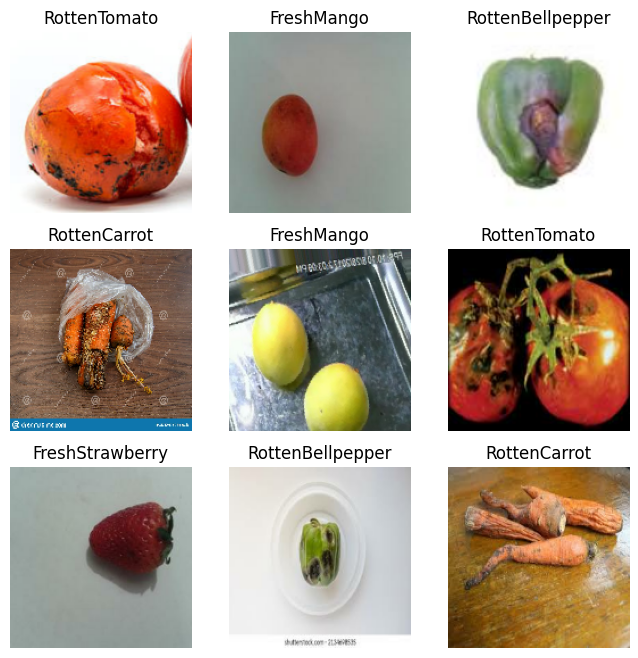

In [23]:
import matplotlib.pyplot as plt

print("Número de clases:", len(CLASS_NAMES))
print("Clases:", CLASS_NAMES)

plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    n = min(9, images.shape[0])
    for i in range(n):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i].numpy().argmax()])
        plt.axis("off")


*Data augmentation*

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")

- Modelo A -baseline-

In [26]:
from tensorflow.keras import models

def build_model_a(input_shape=(160,160,3), num_classes=len(CLASS_NAMES)):
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
model_a = build_model_a(input_shape=input_shape)
model_a.summary()

C:\Users\Yeimi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

- Modelo B más profundo + BN + L2 + Drupout

In [27]:
from tensorflow.keras import regularizers

def build_model_b(input_shape=(160,160,3), num_classes=len(CLASS_NAMES)):
    l2 = regularizers.l2(1e-4)
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, 3, padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(3e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_b = build_model_b(input_shape=input_shape)
model_b.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

- Modelo C Transfer Learning: MobileNetV2

In [28]:
import tensorflow as tf

def build_model_c(input_shape=(160,160,3), num_classes=len(CLASS_NAMES)):
    # intenta pesos ImageNet (si falla, entrena desde cero)
    try:
        base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    except Exception:
        base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights=None)
    base.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_c = build_model_c(input_shape=input_shape)
model_c.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Entrenamiento de los 3 modelos para la comparación y validación**

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os, pandas as pd

os.makedirs("models", exist_ok=True)
callbacks_common = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
]

histories, results = {}, {}

def train_eval(model, key, epochs=20):
    ckpt = f"models/best_{key}.keras"
    hist = model.fit(
        train_ds, validation_data=val_ds, epochs=epochs, verbose=1,
        callbacks=callbacks_common + [ModelCheckpoint(ckpt, save_best_only=True, monitor='val_accuracy')]
    )
    histories[key] = hist.history
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    results[key] = {"val_loss": float(val_loss), "val_acc": float(val_acc), "ckpt": ckpt}

train_eval(model_a, "A", epochs=20)
train_eval(model_b, "B", epochs=25)
train_eval(model_c, "C", epochs=15)

pd.DataFrame(results).T

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.3204 - loss: 1.9004 - val_accuracy: 0.5227 - val_loss: 1.3373 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5368 - loss: 1.2498 - val_accuracy: 0.6818 - val_loss: 1.0811 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.6244 - loss: 1.0389 - val_accuracy: 0.6761 - val_loss: 0.9204 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.7082 - loss: 0.8100 - val_accuracy: 0.7869 - val_loss: 0.6635 - learning_rate: 0.0010
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7445 - loss: 0.7362 - val_accuracy: 0.7841 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.7682 - loss: 0.6882 - val_accuracy: 0.7926 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.7951 - loss: 0.

,val_loss,val_acc,ckpt
A,0.399372,0.909091,models/best_A.keras
B,1.81085,0.178977,models/best_B.keras
C,0.065155,0.985795,models/best_C.keras


Curvas loss/accuracy

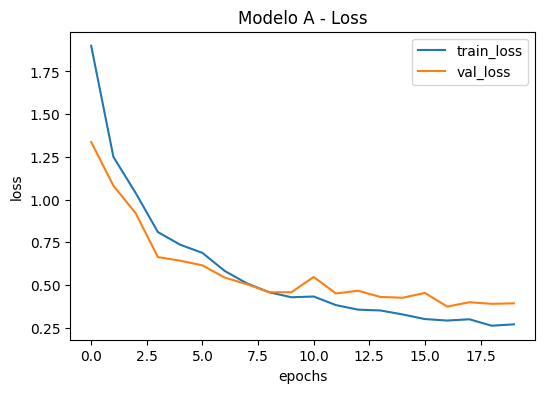

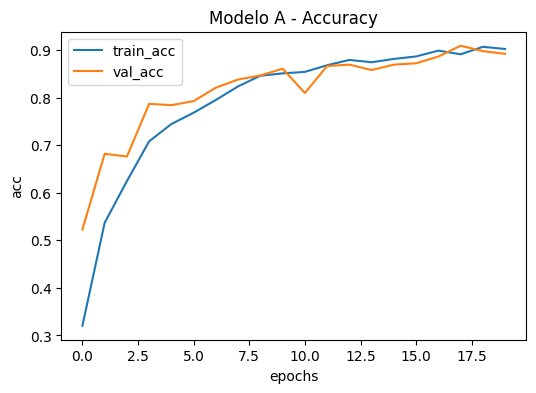

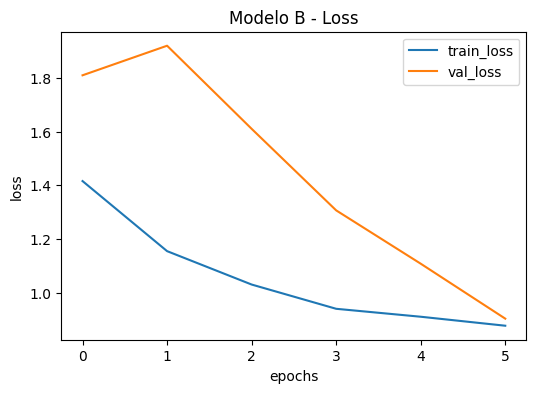

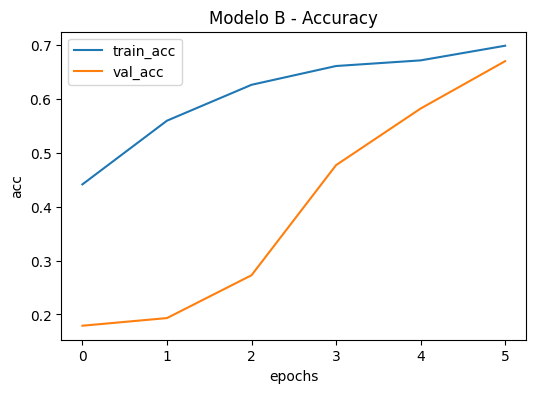

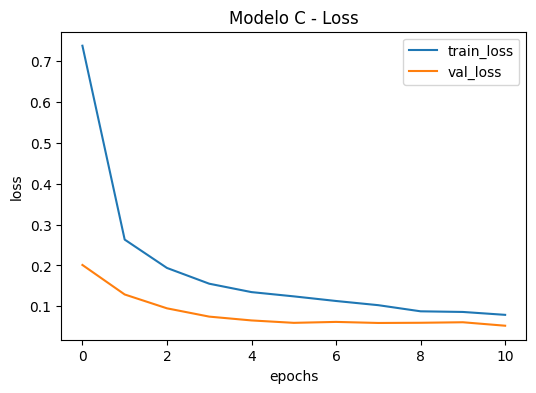

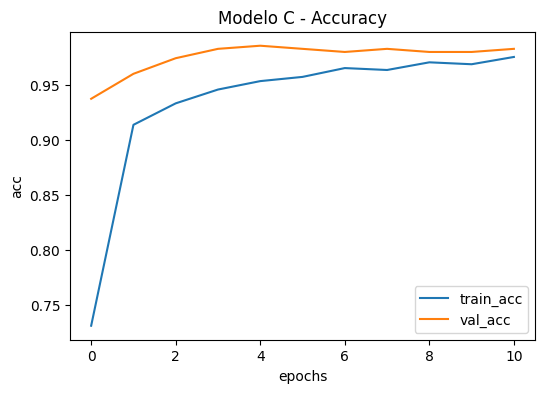

In [30]:
import matplotlib.pyplot as plt

def plot_history(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h.get('loss', []), label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.title(f'{title} - Loss'); plt.xlabel('epochs'); plt.ylabel('loss'); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h.get('accuracy', []), label='train_acc')
    plt.plot(h.get('val_accuracy', []), label='val_acc')
    plt.title(f'{title} - Accuracy'); plt.xlabel('epochs'); plt.ylabel('acc'); plt.legend(); plt.show()

for name, h in histories.items():
    plot_history(h, f"Modelo {name}")

Evaluación en test, reporte y confusión

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# elegir el mejor por val_acc
best_key = max(results.keys(), key=lambda k: results[k]['val_acc'])
best_ckpt = results[best_key]['ckpt']
print(f"Mejor modelo (val_acc): {best_key} → {results[best_key]['val_acc']:.4f}")

best_model = tf.keras.models.load_model(best_ckpt)

# test
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print({"test_loss": float(test_loss), "test_acc": float(test_acc)})

# métricas detalladas
y_true, y_pred = [], []
for x, y in test_ds:
    p = best_model.predict(x, verbose=0)
    y_pred.extend(np.argmax(p, axis=1))
    y_true.extend(np.argmax(y.numpy(), axis=1))

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
cm_df.to_csv("models/confusion_matrix.csv")
cm_df

Mejor modelo (val_acc): C → 0.9858
{'test_loss': 0.10473217815160751, 'test_acc': 0.9670329689979553}
                  precision    recall  f1-score   support

      FreshMango       0.96      1.00      0.98        46
     FreshOrange       0.98      0.97      0.98        65
 FreshStrawberry       1.00      1.00      1.00        62
RottenBellpepper       0.93      0.91      0.92        58
    RottenCarrot       0.98      0.95      0.96        58
    RottenTomato       0.95      0.97      0.96        75

        accuracy                           0.97       364
       macro avg       0.97      0.97      0.97       364
    weighted avg       0.97      0.97      0.97       364



,FreshMango,FreshOrange,FreshStrawberry,RottenBellpepper,RottenCarrot,RottenTomato
FreshMango,46,0,0,0,0,0
FreshOrange,2,63,0,0,0,0
FreshStrawberry,0,0,62,0,0,0
RottenBellpepper,0,0,0,53,1,4
RottenCarrot,0,0,0,3,55,0
RottenTomato,0,1,0,1,0,73


Fine-tuning

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

if best_key == "C":
    base = None
    for layer in best_model.layers:
        if isinstance(layer, tf.keras.Model):
            base = layer
            break
    if base is not None:
        base.trainable = True
        fine_tune_at = len(base.layers) // 2
        for l in base.layers[:fine_tune_at]:
            l.trainable = False

        best_model.compile(optimizer=keras.optimizers.Adam(1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

        hist_ft = best_model.fit(
            train_ds, validation_data=val_ds, epochs=10,
            callbacks=[
                EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
            ],
            verbose=1
        )
        test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
        print({"test_loss_after_finetune": float(test_loss), "test_acc_after_finetune": float(test_acc)})

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.9564 - loss: 0.1226 - val_accuracy: 0.9801 - val_loss: 0.0721 - learning_rate: 1.0000e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9571 - loss: 0.1277 - val_accuracy: 0.9801 - val_loss: 0.0684 - learning_rate: 1.0000e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9623 - loss: 0.1180 - val_accuracy: 0.9830 - val_loss: 0.0644 - learning_rate: 1.0000e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.9661 - loss: 0.1061 - val_accuracy: 0.9801 - val_loss: 0.0690 - learning_rate: 1.0000e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.9634 - loss: 0.1055 - val_accuracy: 0.9830 - val_loss: 0.0634 - learning_rate: 1.0000e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9637 - loss: 0.1032 - val_accuracy: 0.9830 - val_loss: 0.0636 - learning_rate: 1.0000e-04
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accu

In [33]:
import pandas as pd, numpy as np, tensorflow as tf

# Tabla comparativa de validación (usa el dict 'results' creado en la celda de entrenamiento)
df_res = pd.DataFrame(results).T.sort_values("val_acc", ascending=False)
print("== Comparación por validación ==")
display(df_res[["val_loss","val_acc"]])

# Reporte final en test del mejor modelo
print(f"\n== Mejor modelo: {best_key} ==")
print(f"val_acc: {results[best_key]['val_acc']:.4f}")
test_loss, test_acc = tf.keras.models.load_model(results[best_key]["ckpt"]).evaluate(test_ds, verbose=0)
print({"test_loss": float(test_loss), "test_acc": float(test_acc)})

== Comparación por validación ==


,val_loss,val_acc
C,0.065155,0.985795
A,0.399372,0.909091
B,1.81085,0.178977



== Mejor modelo: C ==
val_acc: 0.9858
{'test_loss': 0.10473217815160751, 'test_acc': 0.9670329689979553}


## Detalle de resultados por modelo

- Modelo A — CNN básica (baseline)
Buen punto de partida (val_acc = 0.91), pero al tener solo 2 bloques convolucionales su capacidad fue limitada.
Riesgo de subajuste en clases más complejas.

- Modelo B — CNN más profunda + BN + L2 + Dropout
A pesar de la mayor complejidad, obtuvo un desempeño muy bajo (val_acc = 0.18).
Esto indica que la arquitectura no se ajustó bien al tamaño del dataset (sobreajuste temprano o mal entrenamiento)

- Modelo C — Transfer Learning (MobileNetV2)
Fue el más efectivo (val_acc = 0.986, test_acc = 0.967).
Razón: MobileNetV2 aprovecha features preentrenadas en ImageNet, que capturan bordes, texturas y formas comunes.
Gracias a la combinación de GlobalAveragePooling + Dropout, el modelo logró una excelente generalización con pocas épocas y evitando sobreajuste.
Incluso en clases con confusión visual (pimientos/tomates en mal estado), mantuvo métricas sólidas.

**El Modelo C (MobileNetV2 con Transfer Learning) es el mejor clasificador para este problema:**

- Combina alto desempeño en validación y prueba.

- Generaliza mejor que modelos entrenados desde cero.

- Requiere menos tiempo de entrenamiento y menos datos para alcanzar alta precisión.

- Por estas razones, se selecciona como la arquitectura final para la clasificación de frutas y verduras en este proyecto